# K-means Clustering on Grafana Logs

This notebook applies K-means clustering to Grafana logs and evaluates performance.

## Steps:
1. Load feature matrix
2. Determine optimal number of clusters (Elbow method, Silhouette score)
3. Apply K-means clustering
4. Evaluate clustering quality
5. Visualize clusters
6. Analyze cluster characteristics
7. Benchmark performance

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score, silhouette_samples,
    davies_bouldin_score, calinski_harabasz_score,
    adjusted_rand_score, normalized_mutual_info_score,
    homogeneity_score, completeness_score, v_measure_score
)
from sklearn.decomposition import PCA
import time
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load Data

In [5]:
# Load feature matrix (scaled version for better K-means performance)
X = pd.read_csv('../data/feature_matrix_scaled.csv')
metadata = pd.read_csv('../data/metadata.csv')

print(f"Feature matrix shape: {X.shape}")
print(f"Metadata shape: {metadata.shape}")
print(f"\nAnomaly distribution:")
print(metadata['is_anomaly'].value_counts())

Feature matrix shape: (149999, 45)
Metadata shape: (149999, 6)

Anomaly distribution:
is_anomaly
False    119999
True      30000
Name: count, dtype: int64


## 2. Determine Optimal Number of Clusters

Using Elbow method and Silhouette score.

In [6]:
# # Test different numbers of clusters
# k_range = range(2, 11)
# inertias = []
# silhouette_scores = []
# davies_bouldin_scores = []
# calinski_harabasz_scores = []

# print("Testing different numbers of clusters...")
# for k in k_range:
#     print(f"Testing k={k}...", end=' ')
    
#     kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
#     labels = kmeans.fit_predict(X)
    
#     inertias.append(kmeans.inertia_)
#     silhouette_scores.append(silhouette_score(X, labels))
#     davies_bouldin_scores.append(davies_bouldin_score(X, labels))
#     calinski_harabasz_scores.append(calinski_harabasz_score(X, labels))
    
#     print(f"Silhouette: {silhouette_scores[-1]:.3f}")

# print("\nOptimization complete!")
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import numpy as np

# =========================
# 1️⃣ Sample your dataset
# =========================
n_sample = 5000  # number of samples to speed up computation
np.random.seed(42)
sample_indices = np.random.choice(X.shape[0], n_sample, replace=False)
X_sampled = X.iloc[sample_indices] if hasattr(X, 'iloc') else X[sample_indices]  # works for DataFrame or ndarray

# =========================
# 2️⃣ Optional: Reduce dimensionality
# =========================
pca = PCA(n_components=20, random_state=42)
X_reduced = pca.fit_transform(X_sampled)

# =========================
# 3️⃣ Test different numbers of clusters using MiniBatchKMeans
# =========================
k_range = range(2, 11)
inertias, silhouette_scores, davies_bouldin_scores, calinski_harabasz_scores = [], [], [], []

print("Testing different numbers of clusters on sampled data...")

for k in k_range:
    print(f"Testing k={k}...", end=' ')
    
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=1024, max_iter=200)
    labels = kmeans.fit_predict(X_reduced)
    
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_reduced, labels))
    davies_bouldin_scores.append(davies_bouldin_score(X_reduced, labels))
    calinski_harabasz_scores.append(calinski_harabasz_score(X_reduced, labels))
    
    print(f"Silhouette: {silhouette_scores[-1]:.3f}")

print("\nOptimization complete!")


Testing different numbers of clusters on sampled data...
Testing k=2... Silhouette: 0.188
Testing k=3... Silhouette: 0.176
Testing k=4... Silhouette: 0.162
Testing k=5... Silhouette: 0.160
Testing k=6... Silhouette: 0.157
Testing k=7... Silhouette: 0.214
Testing k=8... Silhouette: 0.185
Testing k=9... Silhouette: 0.183
Testing k=10... Silhouette: 0.190

Optimization complete!


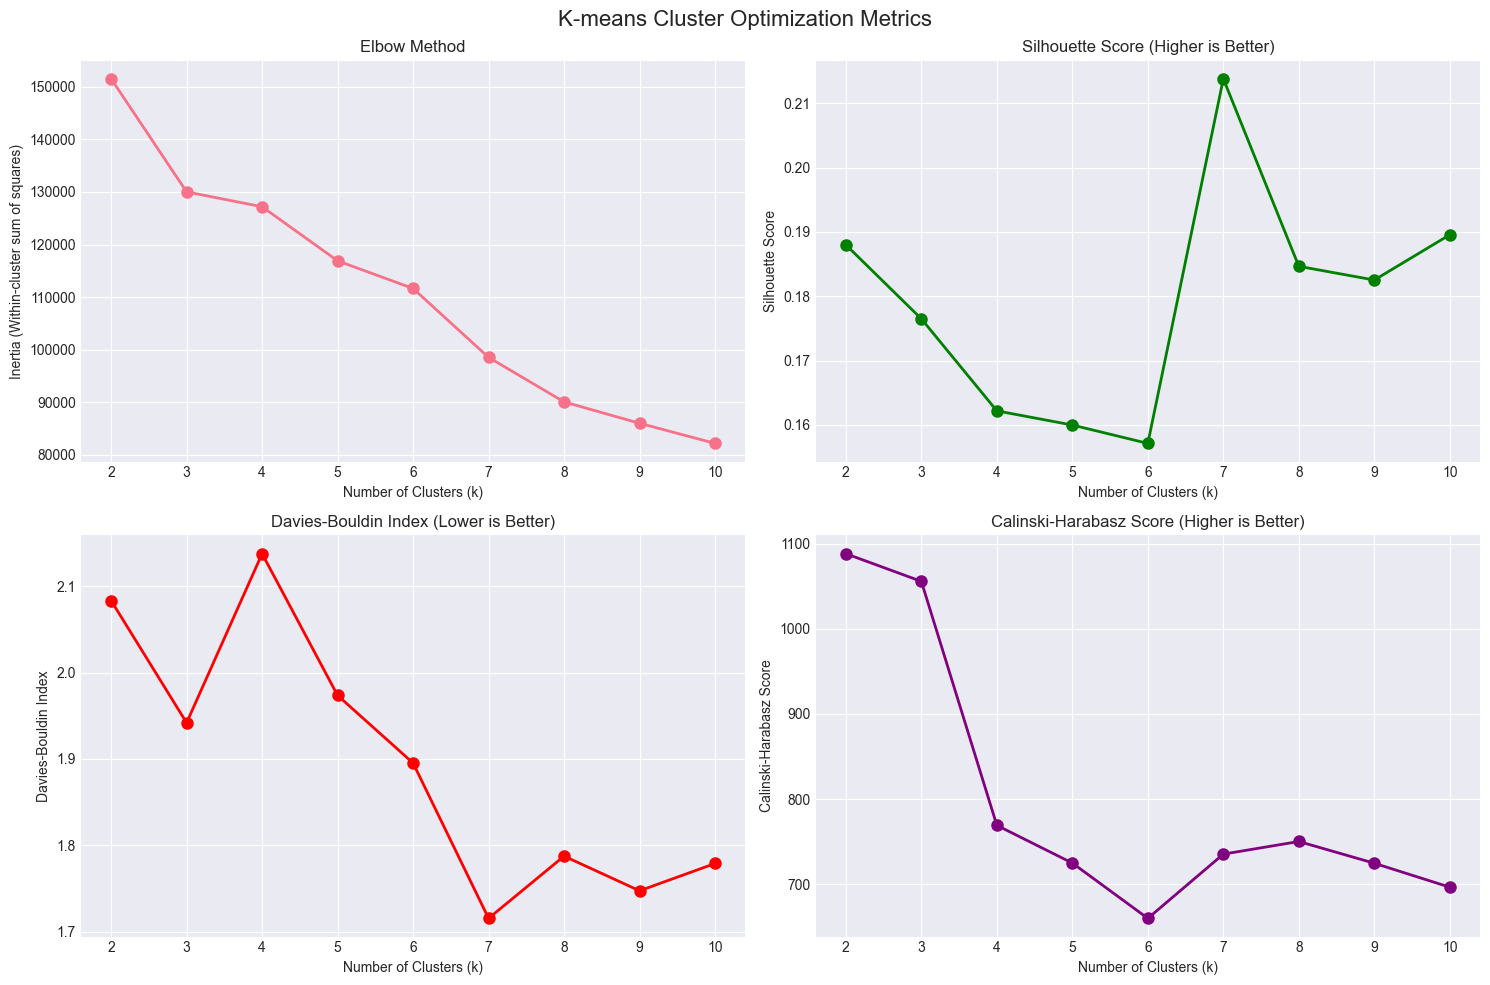


Optimal k based on:
  - Silhouette Score: 7
  - Davies-Bouldin Index: 7
  - Calinski-Harabasz Score: 2


In [7]:
# Plot metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('K-means Cluster Optimization Metrics', fontsize=16)

# Elbow plot
axes[0, 0].plot(k_range, inertias, marker='o', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Number of Clusters (k)')
axes[0, 0].set_ylabel('Inertia (Within-cluster sum of squares)')
axes[0, 0].set_title('Elbow Method')
axes[0, 0].grid(True)

# Silhouette score
axes[0, 1].plot(k_range, silhouette_scores, marker='o', linewidth=2, markersize=8, color='green')
axes[0, 1].set_xlabel('Number of Clusters (k)')
axes[0, 1].set_ylabel('Silhouette Score')
axes[0, 1].set_title('Silhouette Score (Higher is Better)')
axes[0, 1].grid(True)

# Davies-Bouldin Index
axes[1, 0].plot(k_range, davies_bouldin_scores, marker='o', linewidth=2, markersize=8, color='red')
axes[1, 0].set_xlabel('Number of Clusters (k)')
axes[1, 0].set_ylabel('Davies-Bouldin Index')
axes[1, 0].set_title('Davies-Bouldin Index (Lower is Better)')
axes[1, 0].grid(True)

# Calinski-Harabasz Index
axes[1, 1].plot(k_range, calinski_harabasz_scores, marker='o', linewidth=2, markersize=8, color='purple')
axes[1, 1].set_xlabel('Number of Clusters (k)')
axes[1, 1].set_ylabel('Calinski-Harabasz Score')
axes[1, 1].set_title('Calinski-Harabasz Score (Higher is Better)')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

# Find optimal k
optimal_k_silhouette = k_range[np.argmax(silhouette_scores)]
optimal_k_db = k_range[np.argmin(davies_bouldin_scores)]
optimal_k_ch = k_range[np.argmax(calinski_harabasz_scores)]

print(f"\nOptimal k based on:")
print(f"  - Silhouette Score: {optimal_k_silhouette}")
print(f"  - Davies-Bouldin Index: {optimal_k_db}")
print(f"  - Calinski-Harabasz Score: {optimal_k_ch}")

## 3. Apply K-means with Optimal Clusters

In [8]:
# Use the k with best silhouette score
optimal_k = optimal_k_silhouette
print(f"Using k={optimal_k} clusters")

# Benchmark K-means performance
start_time = time.time()

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X)

training_time = time.time() - start_time

print(f"\nK-means training completed in {training_time:.2f} seconds")
print(f"Cluster distribution:")
print(pd.Series(cluster_labels).value_counts().sort_index())

Using k=7 clusters

K-means training completed in 2.64 seconds
Cluster distribution:
0    11900
1    39869
2    13854
3    20515
4    30166
5     9923
6    23772
Name: count, dtype: int64


## 4. Evaluate Clustering Quality

In [9]:
# Calculate metrics
silhouette_avg = silhouette_score(X, cluster_labels)
davies_bouldin = davies_bouldin_score(X, cluster_labels)
calinski_harabasz = calinski_harabasz_score(X, cluster_labels)

print("="*80)
print("K-MEANS CLUSTERING EVALUATION METRICS")
print("="*80)
print(f"Number of clusters: {optimal_k}")
print(f"Training time: {training_time:.2f} seconds")
print(f"\nInternal Validation Metrics:")
print(f"  - Silhouette Score: {silhouette_avg:.4f} (range: [-1, 1], higher is better)")
print(f"  - Davies-Bouldin Index: {davies_bouldin:.4f} (lower is better)")
print(f"  - Calinski-Harabasz Score: {calinski_harabasz:.2f} (higher is better)")
print(f"  - Inertia: {kmeans_final.inertia_:.2f}")

# External validation (if true labels available)
if 'is_anomaly' in metadata.columns:
    true_labels = metadata['is_anomaly'].values
    
    ari = adjusted_rand_score(true_labels, cluster_labels)
    nmi = normalized_mutual_info_score(true_labels, cluster_labels)
    homogeneity = homogeneity_score(true_labels, cluster_labels)
    completeness = completeness_score(true_labels, cluster_labels)
    v_measure = v_measure_score(true_labels, cluster_labels)
    
    print(f"\nExternal Validation Metrics (vs. anomaly labels):")
    print(f"  - Adjusted Rand Index: {ari:.4f} (range: [-1, 1], higher is better)")
    print(f"  - Normalized Mutual Information: {nmi:.4f} (range: [0, 1], higher is better)")
    print(f"  - Homogeneity: {homogeneity:.4f} (range: [0, 1], higher is better)")
    print(f"  - Completeness: {completeness:.4f} (range: [0, 1], higher is better)")
    print(f"  - V-measure: {v_measure:.4f} (range: [0, 1], higher is better)")

print("="*80)

K-MEANS CLUSTERING EVALUATION METRICS
Number of clusters: 7
Training time: 2.64 seconds

Internal Validation Metrics:
  - Silhouette Score: 0.2106 (range: [-1, 1], higher is better)
  - Davies-Bouldin Index: 1.7059 (lower is better)
  - Calinski-Harabasz Score: 25025.30 (higher is better)
  - Inertia: 2773504.14

External Validation Metrics (vs. anomaly labels):
  - Adjusted Rand Index: 0.1420 (range: [-1, 1], higher is better)
  - Normalized Mutual Information: 0.2908 (range: [0, 1], higher is better)
  - Homogeneity: 0.6800 (range: [0, 1], higher is better)
  - Completeness: 0.1850 (range: [0, 1], higher is better)
  - V-measure: 0.2908 (range: [0, 1], higher is better)


## 5. Silhouette Analysis

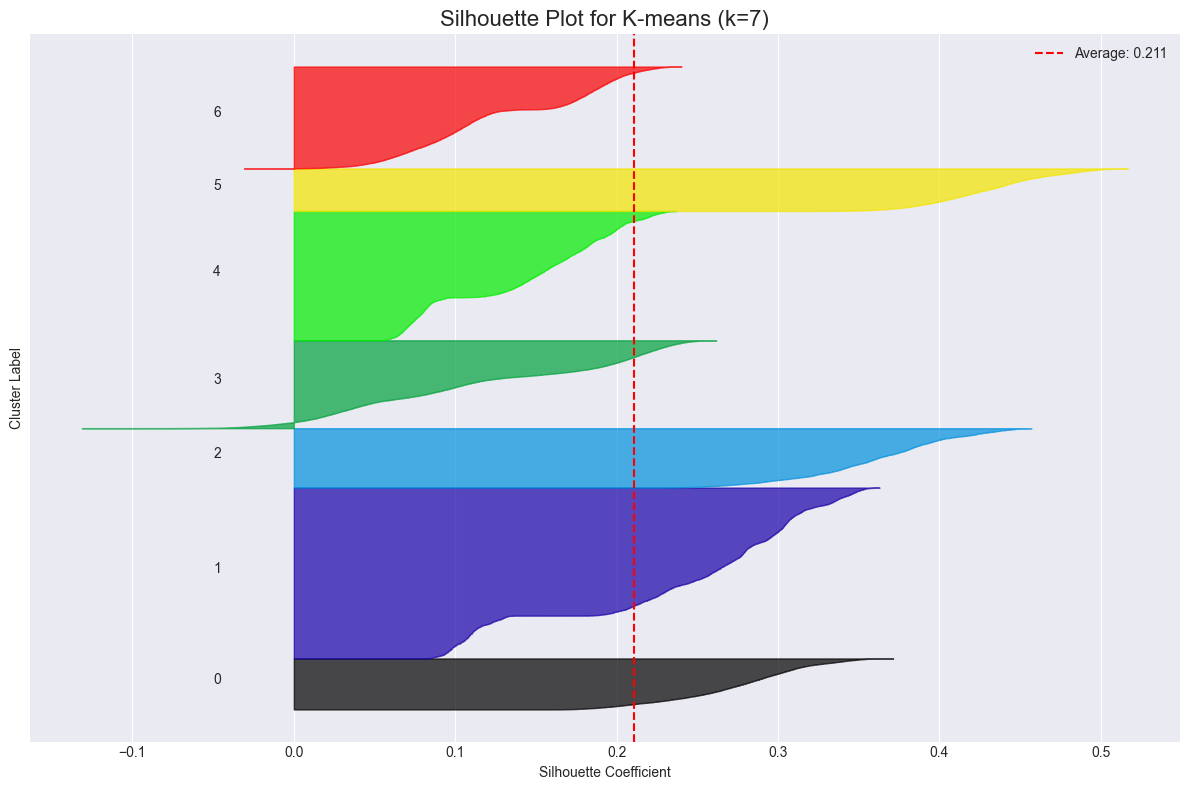

In [10]:
# Compute silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X, cluster_labels)

fig, ax = plt.subplots(figsize=(12, 8))

y_lower = 10
for i in range(optimal_k):
    # Get silhouette scores for samples in cluster i
    cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    cluster_silhouette_values.sort()
    
    size_cluster_i = cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = plt.cm.nipy_spectral(float(i) / optimal_k)
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                     0, cluster_silhouette_values,
                     facecolor=color, edgecolor=color, alpha=0.7)
    
    # Label clusters
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

ax.set_title(f'Silhouette Plot for K-means (k={optimal_k})', fontsize=16)
ax.set_xlabel('Silhouette Coefficient')
ax.set_ylabel('Cluster Label')
ax.axvline(x=silhouette_avg, color="red", linestyle="--", label=f'Average: {silhouette_avg:.3f}')
ax.legend()
ax.set_yticks([])
plt.tight_layout()
plt.show()

## 6. Visualize Clusters (PCA)

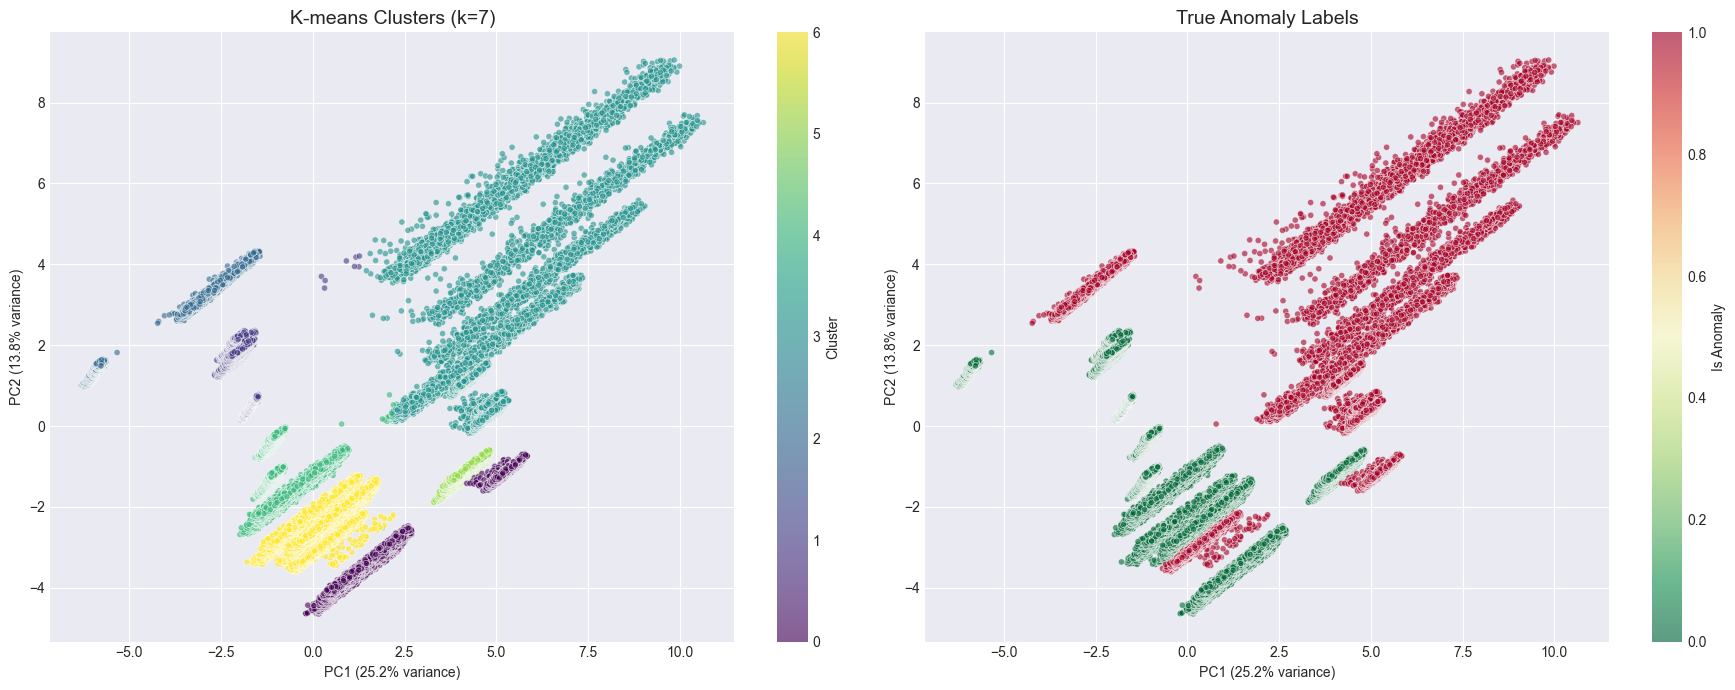

In [11]:
# Reduce to 2D for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot clusters
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], 
                           c=cluster_labels, cmap='viridis', 
                           alpha=0.6, s=20, edgecolors='w', linewidth=0.5)
axes[0].set_title(f'K-means Clusters (k={optimal_k})', fontsize=14)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# Plot true anomaly labels if available
if 'is_anomaly' in metadata.columns:
    scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], 
                               c=metadata['is_anomaly'], cmap='RdYlGn_r', 
                               alpha=0.6, s=20, edgecolors='w', linewidth=0.5)
    axes[1].set_title('True Anomaly Labels', fontsize=14)
    axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
    axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
    plt.colorbar(scatter2, ax=axes[1], label='Is Anomaly')

plt.tight_layout()
plt.show()

## 7. Cluster Characteristics Analysis

In [12]:
# Add cluster labels to metadata
metadata['kmeans_cluster'] = cluster_labels

# Analyze clusters
print("CLUSTER CHARACTERISTICS")
print("="*80)

for cluster_id in range(optimal_k):
    cluster_mask = metadata['kmeans_cluster'] == cluster_id
    cluster_data = metadata[cluster_mask]
    
    print(f"\nCluster {cluster_id}:")
    print(f"  Size: {len(cluster_data):,} ({len(cluster_data)/len(metadata)*100:.1f}%)")
    
    if 'is_anomaly' in metadata.columns:
        anomaly_rate = cluster_data['is_anomaly'].mean() * 100
        print(f"  Anomaly rate: {anomaly_rate:.2f}%")
    
    print(f"  Top services:")
    print(cluster_data['service'].value_counts().head(3))
    
    print(f"  Top panels:")
    print(cluster_data['panel'].value_counts().head(3))

CLUSTER CHARACTERISTICS

Cluster 0:
  Size: 11,900 (7.9%)
  Anomaly rate: 15.75%
  Top services:
service
analytics-service       1775
notification-service    1731
payment-service         1705
Name: count, dtype: int64
  Top panels:
panel
JVM Heap Usage    11900
Name: count, dtype: int64

Cluster 1:
  Size: 39,869 (26.6%)
  Anomaly rate: 0.02%
  Top services:
service
notification-service    5747
product-service         5736
analytics-service       5706
Name: count, dtype: int64
  Top panels:
panel
Response Time P99    10066
Query Duration        9988
Request Rate          9972
Name: count, dtype: int64

Cluster 2:
  Size: 13,854 (9.2%)
  Anomaly rate: 27.33%
  Top services:
service
order-service      2010
api-gateway        1996
payment-service    1994
Name: count, dtype: int64
  Top panels:
panel
Error Rate    13854
Name: count, dtype: int64

Cluster 3:
  Size: 20,515 (13.7%)
  Anomaly rate: 100.00%
  Top services:
service
notification-service    2970
api-gateway             2963
payme

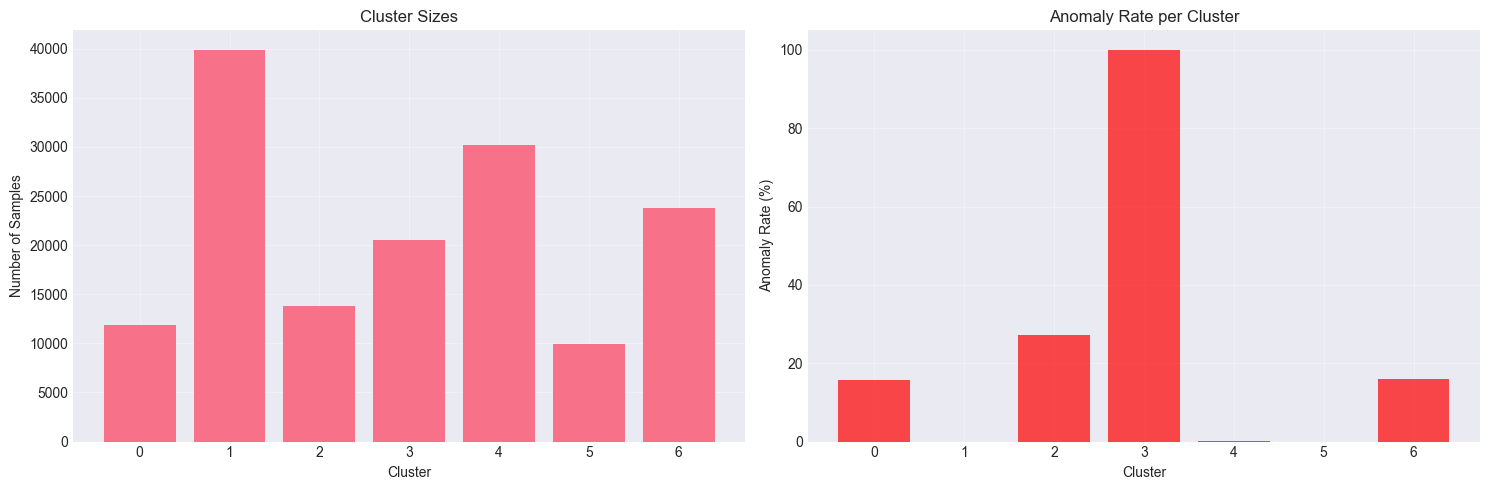

In [13]:
# Visualize cluster characteristics
if 'is_anomaly' in metadata.columns:
    # Anomaly distribution per cluster
    cluster_anomaly = metadata.groupby('kmeans_cluster')['is_anomaly'].agg(['sum', 'count', 'mean'])
    cluster_anomaly['anomaly_rate'] = cluster_anomaly['mean'] * 100
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Cluster sizes
    axes[0].bar(range(optimal_k), cluster_anomaly['count'])
    axes[0].set_xlabel('Cluster')
    axes[0].set_ylabel('Number of Samples')
    axes[0].set_title('Cluster Sizes')
    axes[0].grid(True, alpha=0.3)
    
    # Anomaly rates
    axes[1].bar(range(optimal_k), cluster_anomaly['anomaly_rate'], color='red', alpha=0.7)
    axes[1].set_xlabel('Cluster')
    axes[1].set_ylabel('Anomaly Rate (%)')
    axes[1].set_title('Anomaly Rate per Cluster')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 8. Save Results

In [14]:
# Save cluster labels
metadata.to_csv('../data/kmeans_results.csv', index=False)
print("K-means results saved!")

# Save metrics
metrics = {
    'algorithm': 'K-means',
    'n_clusters': optimal_k,
    'training_time': training_time,
    'silhouette_score': silhouette_avg,
    'davies_bouldin_index': davies_bouldin,
    'calinski_harabasz_score': calinski_harabasz,
    'inertia': kmeans_final.inertia_
}

if 'is_anomaly' in metadata.columns:
    metrics.update({
        'adjusted_rand_index': ari,
        'normalized_mutual_info': nmi,
        'homogeneity': homogeneity,
        'completeness': completeness,
        'v_measure': v_measure
    })

metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv('../data/kmeans_metrics.csv', index=False)
print("K-means metrics saved!")

print("\nK-means clustering complete!")

K-means results saved!
K-means metrics saved!

K-means clustering complete!
